In [ ]:
# to do

# add comments under results from log rank test
# add comments under cox proportional hazards model

# add more EDA 

In [81]:
# general packages
import pandas as pd
import numpy as np

# specialized stats packages
from lifelines import KaplanMeierFitter

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preferences
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data
from lifelines.datasets import load_psychiatric_patients

df = load_psychiatric_patients()

In [3]:
df.head()

,Age,T,C,sex
0,51,1,1,2
1,58,1,1,2
2,55,2,1,2
3,28,22,1,2
4,21,30,0,1


In [4]:
df.describe()

,Age,T,C,sex
count,26.000000,26.000000,26.000000,26.000000
mean,35.153846,26.423077,0.538462,1.576923
std,10.479284,11.559146,0.508391,0.503831
min,19.000000,1.000000,0.000000,1.000000
25%,28.250000,22.500000,0.000000,1.000000
50%,32.500000,30.500000,1.000000,2.000000
75%,42.500000,34.750000,1.000000,2.000000
max,58.000000,40.000000,1.000000,2.000000


# Plotting lifetimes

In [70]:
# the function below is a modified version of plotting function from the lifetimes library. All credit should go to
# them and all faults are mine.

def plot_lifetimes(lifetimes, event_observed=None, birthtimes=None,
                   order=False, block=True):
    """
    Parameters:
      lifetimes: an (n,) numpy array of lifetimes.
      event_observed: an (n,) numpy array of booleans: True if event observed, else False.
      birthtimes: an (n,) numpy array offsetting the births away from t=0.
    Creates a lifetime plot, see
    examples:
    """
    from matplotlib import pyplot as plt

    N = lifetimes.shape[0]
    if N > 100:
        print("warning: you may want to subsample to less than 100 individuals.")

    if event_observed is None:
        event_observed = np.ones(N, dtype=bool)

    if birthtimes is None:
        birthtimes = np.zeros(N)

    if order:
        """order by length of lifetimes; probably not very informative."""
        ix = np.argsort(lifetimes, 0)
        lifetimes = lifetimes[ix, 0]
        event_observed = event_observed[ix, 0]
        birthtimes = birthtimes[ix]
    
    fig, ax = plt.subplots(figsize=[15,5], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for i in range(N):
        c = "#663366" if event_observed[i] else "green"
        l = 'burned by the sun rays or an angry mob' if event_observed[i] else "alive"
        
        plt.hlines(N - 1 - i, birthtimes[i], birthtimes[i] + lifetimes[i], color=c, lw=3, label=l if (i == 0) or (i==40)  else "")
        m = "|" if not event_observed[i] else 'o'
        plt.scatter((birthtimes[i]) + lifetimes[i], N - 1 - i, color=c, s=30, marker=m)
        plt.legend(fontsize=16)

    plt.xlabel("Number of years since becoming a vampire", size=18)
    plt.ylabel("Individual vampires", size=20)
    plt.vlines(current_time, 0, N, lw=2, linestyles='--', alpha=0.5)
    plt.xticks(fontsize=18)
    plt.ylim(-0.5, N)
    return

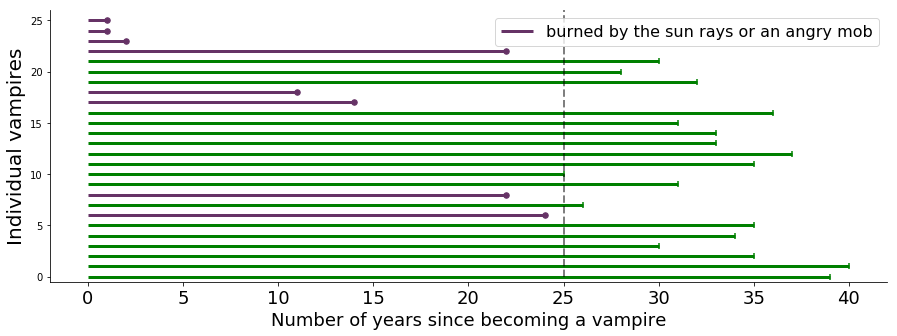

In [71]:
current_time = 25
actual_lifetimes = df['T'].values
observed_lifetimes = actual_lifetimes
observed = actual_lifetimes < current_time

plot_lifetimes(observed_lifetimes, event_observed=observed, block=True)

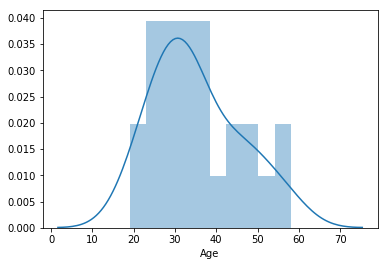

In [85]:
sns.distplot(df["Age"], bins=10);

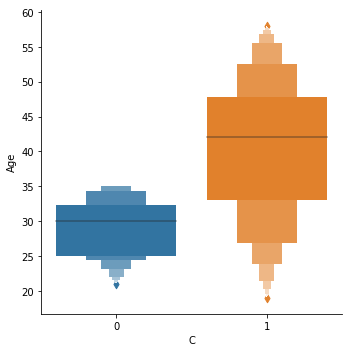

In [75]:
sns.catplot(x="C", y="Age", kind="boxen",
            data=df.sort_values("C"));

# Kaplan-Meier curve

In [6]:
kmf = KaplanMeierFitter()
T = df["T"] #duration
C = df["C"] 

In [7]:
kmf.fit(T,C);

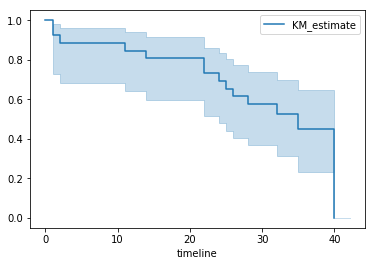

In [8]:
kmf.survival_function_
kmf.median_
kmf.plot()

## Kaplan-Meier curve plotted separately for men and women

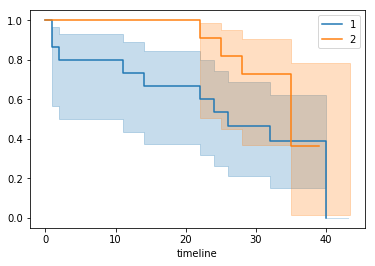

In [10]:
# plot both genders on the same plot

groups = df['sex']
ix = (groups == 1)

kmf.fit(T[~ix], C[~ix], label='1')
ax = kmf.plot()

kmf.fit(T[ix], C[ix], label='2')
kmf.plot(ax=ax)

# Hazard rate using Nelson-Aalen estimator

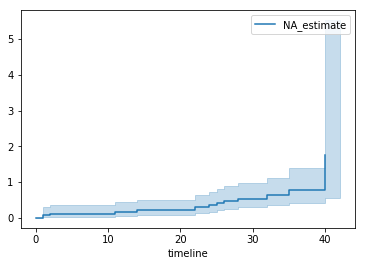

In [22]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(T,event_observed=C);
naf.plot()

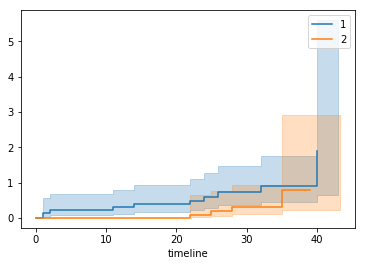

In [23]:
naf.fit(T[~ix], C[~ix], label='1')
ax = naf.plot()

naf.fit(T[ix], C[ix], label='2')
naf.plot(ax=ax)

# Statistical analysis of differences

## Is there a difference between survival rate for two groups? Log rank test

In [12]:
 from lifelines.statistics import logrank_test

 results = logrank_test(T[ix], T[~ix], event_observed_A=C[ix], event_observed_B=C[~ix])
 results.print_summary()

Results
   t 0: -1
   test: logrank
   alpha: 0.95
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.20485 |              1.607 |  Cannot Reject Null |       False       


## What factors influence the survival? Cox Proportional Hazards Model

In [14]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df, duration_col='T', event_col='C', show_progress=True)

cph.print_summary()  

Convergence completed after 5 iterations.
n=26, number of events=14

       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Age  0.2075     1.2306    0.0583  3.5606 0.0004      0.0933      0.3218  ***
sex -0.5237     0.5923    0.7375 -0.7101 0.4776     -1.9696      0.9221     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.816
